In [1]:
import numpy as np 
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt 
import itertools
import scprep
from sklearn.metrics import adjusted_rand_score as ari
from anticor_features.anticor_features import get_anti_cor_genes
import singleCellHaystack as hs
import giniclust3 as gc
from SEMITONES.cell_selection import from_knn_dist
from SEMITONES.enrichment_scoring import calculate_escores
from SEMITONES.enrichment_scoring import permute
from SEMITONES.enrichment_scoring import sig_interval
from SEMITONES.support_funcs import pairwise_similarities
from SEMITONES.support_funcs import sig_dictionary
from sklearn.metrics.pairwise import pairwise_kernels
from sklearn.metrics import roc_curve, auc

In [ ]:
# test data
adata = sc.read_h5ad('Tamer_benchmark/simulation/tamer.h5ad')
adata_raw = sc.read_h5ad('Tamer_benchmark/simulation/tamer_raw.h5ad')
adata_test = adata_raw[:,0:1300].copy()

In [2]:
def dimension_reduce(adata):
    sc.tl.pca(adata, svd_solver='arpack')
    sc.pp.neighbors(adata, n_neighbors=20, n_pcs=20)
    return adata

In [35]:
def ROC(label, result):
    fpr, tpr, thresholds = roc_curve(label, result)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
    plt.axis('off') 
    for spine in plt.gca().spines.values():
        spine.set_visible(False)
    plt.show()
    print(f"AUC值为: {roc_auc:.4f}")

In [36]:
def ROC(label, result):
    colors = ['darkorange', 'green', 'red', 'blue']
    names = ['Anti-correlation', 'Gini', 'schaystack', 'Semitones']

    plt.figure(figsize=(8, 8))
    for i, (prob, name, color) in enumerate(zip(result, names, colors)):
        fpr, tpr, _ = roc_curve(label, prob)
        roc_auc = auc(fpr, tpr)
        plt.plot(
            fpr, tpr, 
            color=color, 
            lw=2, 
            label=f'{name} (AUC = {roc_auc:.3f})'
        )

    plt.axis('off')
    for spine in plt.gca().spines.values():
        spine.set_visible(False)

    plt.legend(
        loc='lower right', 
        frameon=True, 
        fontsize=10, 
        edgecolor='black'
    )

    plt.tight_layout()
    plt.show()

    for i, (prob, name) in enumerate(zip(result, names)):
        fpr, tpr, _ = roc_curve(label, prob)
        roc_auc = auc(fpr, tpr)
        print(f"{name}: AUC = {roc_auc:.4f}")

anti
found 3809.66719488 free Gb in /tmp
get_all_remove_genes
8400 420
min_express_n 50
get_n_expressed
pre_remove_feature: 0
pre_remove_pathway: 0
pre_remove_low_express: 0
0  genes to remove out of  1300
rewriting the filtered dataset
/tmp/exprs.hdf5
total_vars: 1300
making the hdf5 spearman output file
/tmp/spearman.hdf5
get_the_spears
total_vars 1300
	getting spearman correlation
empirically determined Cneg cutoff: -0.039432711816334676  for FPR of: 0.0002
empirically determined Cpos cutoff: 0.04197881774618101  for FPR of: 0.0002
get_real_spear
[0, 1300]
working on 0 1300 vs 0 1300
	getting spearman correlation
      gene  pre_remove_feature  pre_remove_pathway  pre_remove_low_express  \
0        0               False               False                   False   
1        1               False               False                   False   
2        2               False               False                   False   
3        3               False               False              

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1300/1300 [00:01<00:00, 1001.66it/s]


> calculating feature's CV ...
> selecting genes to randomize ...
> calculating randomized KLD ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:11<00:00,  8.78it/s]


> calculating P values ...
> done.
Gene number is 1300
Cell number is 8400
Start enrichment scoring
Enrichment scoring complete
Start enrichment scoring
Enrichment scoring complete


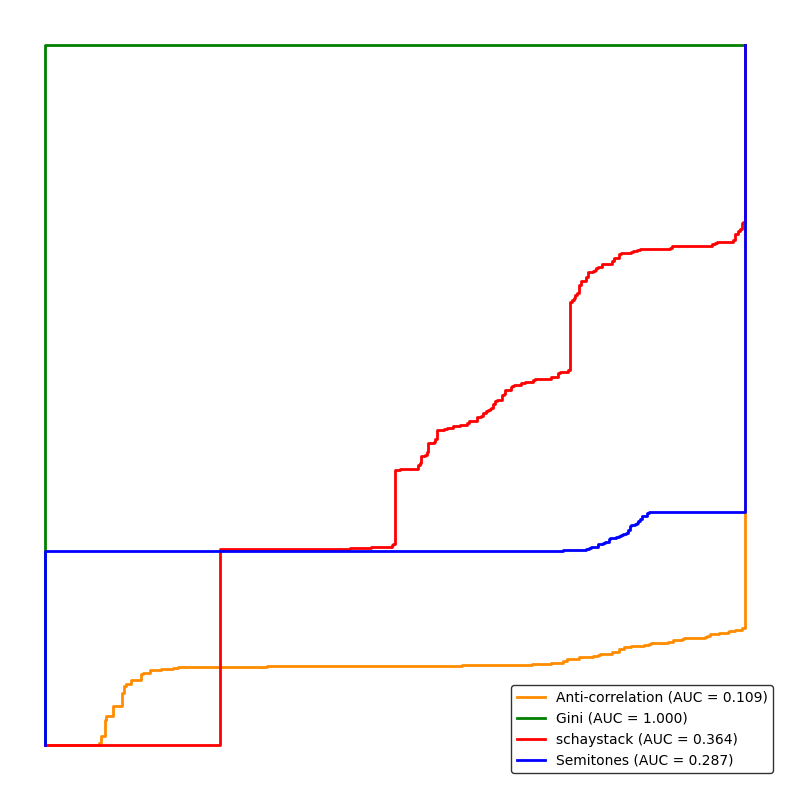

Anti-correlation: AUC = 0.1087
Gini: AUC = 1.0000
schaystack: AUC = 0.3638
Semitones: AUC = 0.2875


In [37]:
if __name__ == "__main__":
    adata_test.var_names_make_unique()

    # anticor
    adata_anti = adata_test.copy()
    sc.pp.normalize_total(adata_anti)
    print('anti')
    anti_cor_table = get_anti_cor_genes(
        adata_anti.X.T,
        adata_anti.var.index.tolist(),
        species="hsapiens",
        pre_remove_pathways=[],
        FPR=0.0002,
        FDR=1/40
    )
    selected_table = anti_cor_table[anti_cor_table["selected"]==True]
    print(selected_table)

    adata_anti.var = pd.concat([adata_anti.var,anti_cor_table], axis=1)

    adata_anti.raw = adata_anti
    adata_anti = adata_anti[:, selected_table.index]

    # schaystack
    adata_hs = adata_test.copy()
    adata_hs.layers["counts"] = adata_hs.X.copy()
    sc.pp.normalize_total(adata_hs)
    sc.pp.log1p(adata_hs)

    adata_hs = dimension_reduce(adata_hs)
    res = hs.haystack(adata_hs, coord="X_pca")

    # giniclust
    adata_tem = adata_test.copy()
    sc.pp.log1p(adata_tem)
    gc.gini.calGini(adata_tem, min_gini_value=0.1, neighbors=3, p_value=0.05)
    adata_gini = adata_tem.copy()
    # semitones
    adata_tem = adata_test.copy()
    adata_tem.layers["counts"] = adata_tem.X.copy()
    sc.pp.normalize_total(adata_tem)
    sc.pp.log1p(adata_tem)
    adata_tem = dimension_reduce(adata_tem)
    S = pairwise_kernels(adata_tem.obsm['X_pca'], metric="rbf", gamma=8.6e-4)  # pariwise similarities
    median = np.median(S, axis=0)
    start = int(np.argmin(median))

    dd_rcells = from_knn_dist(
        X=adata_tem.obsm['X_pca'],  # search in the 20 PC space
        n_ret=17,
        start=start,  # provide the least similar cell
        # metric="rbf",  # define the (dis)similarity metric
        metric_params={"gamma": 8.6e-4}
        )  # provide the gamma

    S = pairwise_similarities(
        adata_tem.obsm['X_pca'],
        query=dd_rcells,  
        # metric="rbf",  # metric as in notebook 1
        metric_params={"gamma": 8.6e-4}
        )
    
    escores = calculate_escores(adata_tem.X, query=dd_rcells, S=S)
    P = permute(adata_test.X)
    pscores = calculate_escores(P, query=dd_rcells, S=S)
    interval = sig_interval(pscores, n_sds=8)
    sigdict = sig_dictionary(escores, interval)
    subset = list({x for v in sigdict.values() for x in v})
    adata_semi = adata_test[:, subset].copy()

    result = [-np.array(selected_table['FDR'].to_list()), adata_gini.var['gini_value'], -res.result['pval_adj'], escores.max(axis=1)]

    ROC(label, result)


In [26]:
label = [1]*900 + [0]*400

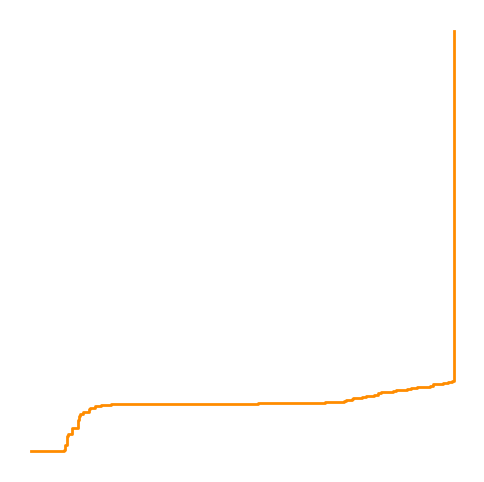

AUC值为: 0.1087


In [31]:
ROC(label, -np.array(selected_table['FDR'].to_list()))

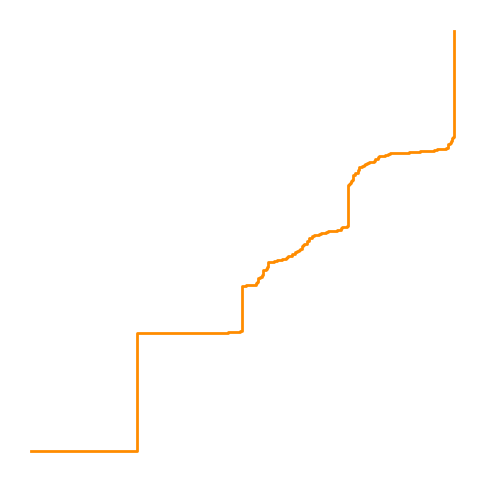

AUC值为: 0.3638


In [32]:
ROC(label, -res.result['pval_adj'])

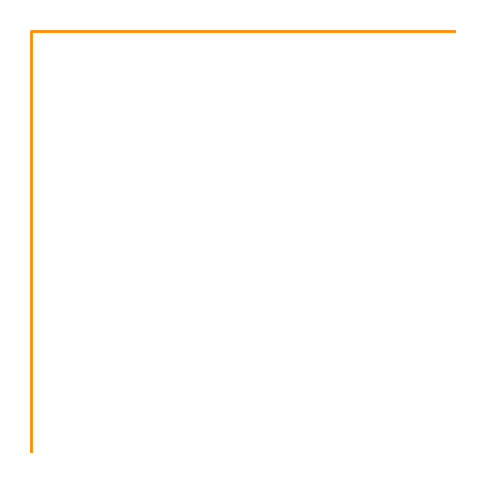

AUC值为: 1.0000


In [33]:
ROC(label, adata_gini.var['gini_value'])

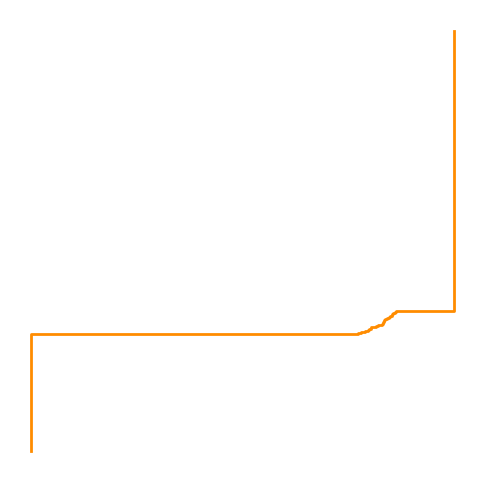

AUC值为: 0.2875


In [34]:
ROC(label, escores.max(axis=1))